In [1]:
# Analysis for CT Pretrial Detainees
# (Springboard Capstone 1)
# 2019, Misty M. Giles

# Import everything.  
%matplotlib inline
from datetime import datetime as date
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Select the file created in CT_csv (unit 5 data wrangling assignment)
file = 'detainees_classed_offenses.csv'

In [2]:
# Read in the file
df = pd.read_csv(file, parse_dates=['download_date', 'latest_admission_date'])

# This corrects a typo that's being fixed in CT_csv.
df['offense_class'] = [offense[-2:] if offense.endswith(('AM','BM','CM','DM','UM',' M', 
                       'AF','BF','CF','DF','UF',' F')) else np.nan for offense in df.offense]

# Days that CT says a detainee has been in the system.  This doesn't account for
# some detainees.  There are 730 days in the dataset, and the state says that entrance 
# dates over a year before could be original entrance date but are definitely not to be
# trusted.  The days column will be capped at 1,095 (730 + 365).  This is definitely going
#  to need further investigation.
df.days = [int(time[:-23]) for time in df.days]
df.days = [time if time <= 1095 else 1095 for time in df.days]

# Check that everything worked.  In this EDA, there should be 0 null values.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28808 entries, 0 to 28807
Data columns (total 13 columns):
download_date            28808 non-null datetime64[ns]
identifier               28808 non-null object
latest_admission_date    28808 non-null datetime64[ns]
race                     28808 non-null object
gender                   28808 non-null object
age                      28808 non-null int64
bond_amount              28808 non-null int64
offense                  28808 non-null object
facility                 28808 non-null object
detainer                 28808 non-null object
offense_class            28808 non-null object
days                     28808 non-null int64
counts                   28808 non-null int64
dtypes: datetime64[ns](2), int64(4), object(7)
memory usage: 2.9+ MB


In [3]:
# Only working with the 94% under 80k.
df = df.loc[df.bond_amount<=80000]
print(df.info())

# Separate out the two datasets, misdemeanor (primary) and felony.
felony_df = df.loc[df['offense_class'].str.endswith('F')]
misdemeanor_df = df.loc[df['offense_class'].str.endswith('M')]

# Divide the misdemeanor data into pre-enactment and post.
date_pre = pd.date_range(start='7/1/2016', end='6/30/2017', freq='D').tolist()
date_post = pd.date_range(start='7/1/2017', end='6/30/2018', freq='D').tolist()
date_end = pd.date_range(start='7/1/2018', end='11/30/2018', freq='D').tolist()
mis_pre_df = misdemeanor_df.loc[misdemeanor_df.download_date < '2017-07-01']
mis_post_df = misdemeanor_df.loc[misdemeanor_df.download_date >= '2017-07-01']
mis_post_df = mis_post_df.loc[mis_post_df.download_date < '2018-07-01']
mis_outofbounds_df = misdemeanor_df.loc[misdemeanor_df.download_date >= '2018-07-01']
mis_df = pd.concat([mis_pre_df, mis_post_df])

# Change race, gender, facility, and detainer to category type and verify.
df.race = df.race.astype('category')
df.gender = df.gender.astype('category')
df.facility = df.facility.astype('category')
df.detainer = df.detainer.astype('category')
df.offense_class = df.offense_class.astype('category')

# Seed for repeatability
np.random.seed(42)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21175 entries, 1 to 28807
Data columns (total 13 columns):
download_date            21175 non-null datetime64[ns]
identifier               21175 non-null object
latest_admission_date    21175 non-null datetime64[ns]
race                     21175 non-null object
gender                   21175 non-null object
age                      21175 non-null int64
bond_amount              21175 non-null int64
offense                  21175 non-null object
facility                 21175 non-null object
detainer                 21175 non-null object
offense_class            21175 non-null object
days                     21175 non-null int64
counts                   21175 non-null int64
dtypes: datetime64[ns](2), int64(4), object(7)
memory usage: 2.3+ MB
None


In [4]:
target = pd.DataFrame(mis_pre_df.bond_amount)
data = mis_pre_df.drop(['identifier','bond_amount','counts', 
                        'download_date','latest_admission_date',
                        'offense','detainer','facility','age','days'], axis=1)
data = pd.get_dummies(data,columns=['offense_class','race','gender'])
data.drop('offense_class_UM',axis=1,inplace=True)
data.drop('race_ASIAN',axis=1,inplace=True)
data.drop('race_AMER IND',axis=1,inplace=True)
target.shape, data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3689 entries, 3 to 28799
Data columns (total 9 columns):
offense_class_ M    3689 non-null uint8
offense_class_AM    3689 non-null uint8
offense_class_BM    3689 non-null uint8
offense_class_CM    3689 non-null uint8
race_BLACK          3689 non-null uint8
race_HISPANIC       3689 non-null uint8
race_WHITE          3689 non-null uint8
gender_F            3689 non-null uint8
gender_M            3689 non-null uint8
dtypes: uint8(9)
memory usage: 61.2 KB


((3689, 1), None)

In [5]:
X = data
y = target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3)

lm = LinearRegression().fit(X_train,y_train)

test = lm.predict(X_test)
lm.score(X_test,y_test)

0.03899950278724629

In [6]:
from statsmodels.formula.api import ols
sm_df = pd.get_dummies(mis_pre_df,columns=['offense_class','race','gender']).rename(
    index=str, columns={'offense_class_ M':'offense_class_M'})

# Same result for gender_M or gender_F
m = ols('bond_amount ~ gender_M',sm_df).fit()
print(m.summary())

                            OLS Regression Results                            
Dep. Variable:            bond_amount   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     45.59
Date:                Wed, 27 Mar 2019   Prob (F-statistic):           1.69e-11
Time:                        21:24:33   Log-Likelihood:                -41346.
No. Observations:                3689   AIC:                         8.270e+04
Df Residuals:                    3687   BIC:                         8.271e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   9901.1087    698.113     14.183      0.0

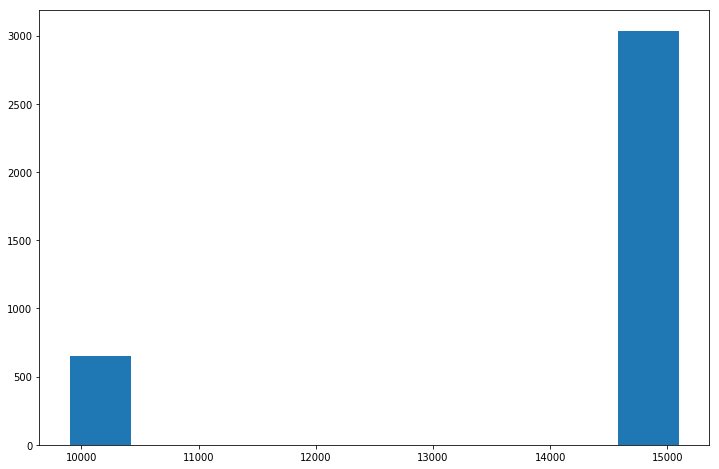

In [7]:
_, ax = plt.subplots(figsize=(12,8))
_ = plt.hist(m.fittedvalues)

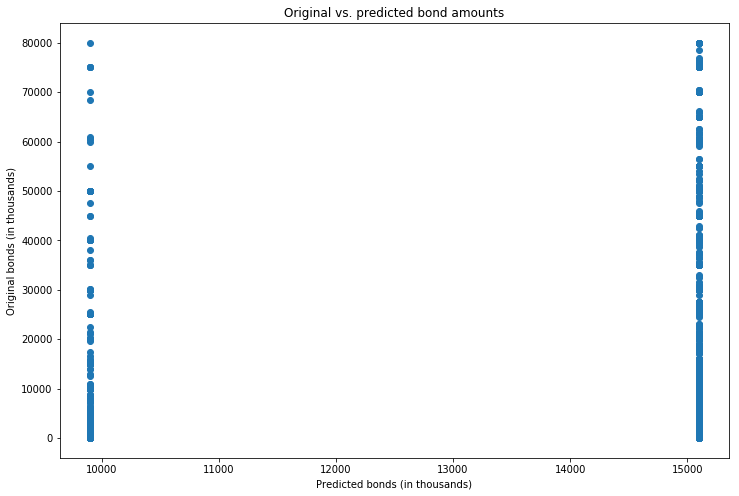

In [8]:
_, ax = plt.subplots(figsize=(12,8))
_ = plt.scatter(m.fittedvalues, sm_df.bond_amount)
_ = plt.xlabel('Predicted bonds (in thousands)')
_ = plt.ylabel('Original bonds (in thousands)')
_ = plt.title('Original vs. predicted bond amounts')

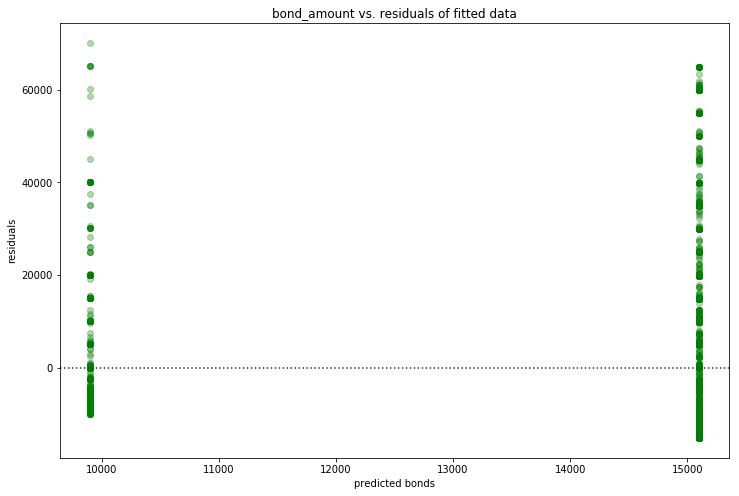

In [9]:
# Plot the bond_amount vs the residuals
_ = plt.figure(figsize=(12,8))
_ = sns.residplot(m.fittedvalues, m.resid, color='g', scatter_kws={'alpha': .3}, 
                  line_kws={'color':'purple', 'alpha':.8})
_ = plt.xlabel('predicted bonds')
_ = plt.ylabel('residuals')
_ = plt.title('bond_amount vs. residuals of fitted data')

In [10]:
m = ols('bond_amount ~ offense_class_AM',sm_df).fit()
print(m.summary())

# offense_class_M gives 33ish F-stat, BM/CM are less than 20

                            OLS Regression Results                            
Dep. Variable:            bond_amount   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     57.55
Date:                Wed, 27 Mar 2019   Prob (F-statistic):           4.15e-14
Time:                        21:24:36   Log-Likelihood:                -41340.
No. Observations:                3689   AIC:                         8.268e+04
Df Residuals:                    3687   BIC:                         8.270e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         1.045e+04    572.763  

In [11]:
m = ols('bond_amount ~ race_WHITE',sm_df).fit()
print(m.summary())

# Race alone is crap predictor.  Highest F-stat was less than 10.

                            OLS Regression Results                            
Dep. Variable:            bond_amount   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     9.485
Date:                Wed, 27 Mar 2019   Prob (F-statistic):            0.00209
Time:                        21:24:36   Log-Likelihood:                -41364.
No. Observations:                3689   AIC:                         8.273e+04
Df Residuals:                    3687   BIC:                         8.274e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.496e+04    388.970     38.454      0.0

In [12]:
# Highest F-stat of the above tests
### VIRTUALLY IDENTICAL FOR ALL THREE RACES
### IDENTICAL FOR BOTH GENDERS
### Meh for other offense classes
m = ols('bond_amount ~ race_WHITE + gender_M + offense_class_AM',sm_df).fit()
print(m.summary())

                            OLS Regression Results                            
Dep. Variable:            bond_amount   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     38.65
Date:                Wed, 27 Mar 2019   Prob (F-statistic):           1.38e-24
Time:                        21:24:36   Log-Likelihood:                -41311.
No. Observations:                3689   AIC:                         8.263e+04
Df Residuals:                    3685   BIC:                         8.266e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         6237.8563    941.975  

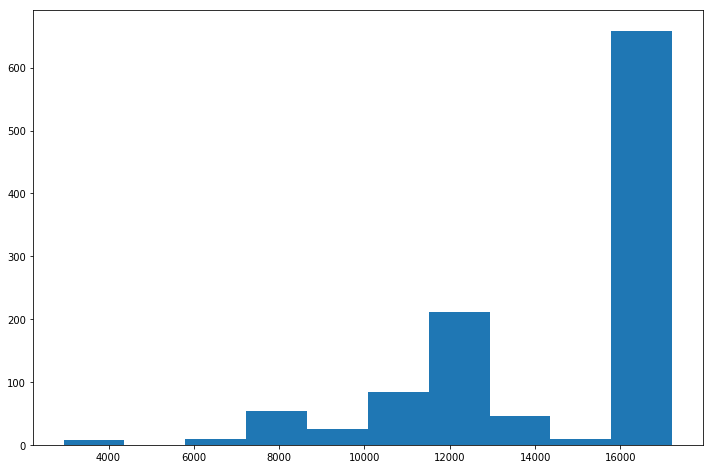

In [13]:
_, ax = plt.subplots(figsize=(12,8))
_ = plt.hist(test)

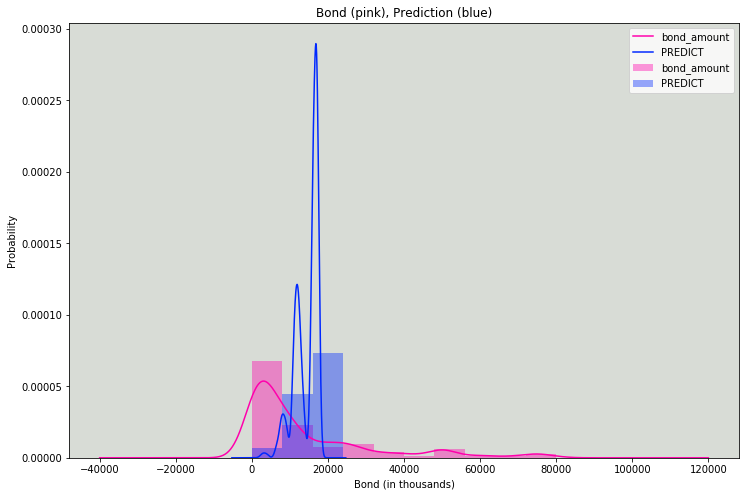

In [16]:
new = target.copy()
new['PREDICT'] = lm.predict(X)

from matplotlib import cm
color_country = cm.hsv(np.linspace(.9,.65, 2))
dist = new[['bond_amount', 'PREDICT']].copy()
fig, ax = plt.subplots(figsize=(12,8))
dist.plot.kde(ax=ax, title='Bond (pink), Prediction (blue)', color=color_country)
dist.plot.hist(density=True, ax=ax, alpha=.4, color=color_country)
ax.set_ylabel('Probability')
ax.set_facecolor('#d8dcd6')
ax.set_xlabel('Bond (in thousands)');